# MVDR Performance: Clean vs. Noisy Audio Comparison

This notebook compares the MVDR beamformer's performance between clean and noisy input signals at different SNR levels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf # For reading audio if needed
import pandas as pd # For data handling
from typing import Dict, Tuple, Any
import torch # Import PyTorch

# Import the custom modules 
from beamform import util
from beamform import util_torch
from beamform import mvdr
from beamform import mvdr_torch
import audio_generation
import audio_generation_torch

In [2]:
# ================================================
# Setup Device (CPU or GPU if available)
# ================================================
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")
# ================================================

Using CPU


In [3]:
def get_default_params() -> Dict[str, Any]:
    """Returns a dictionary containing the default parameters for the analysis."""
    params = {
        # Audio Parameters
        "TEST_FREQUENCY": 1000,
        "DURATION": 1.0,
        "SAMPLING_FREQUENCY": 16000,

        # STFT Parameters
        "FFT_LENGTH": 512,
        "FFT_SHIFT": 256,
        "FRAME_LENGTH": 512, # Keep equal to FFT_LENGTH for PyTorch STFT/iSTFT

        # Array Geometry Parameters
        "SOUND_SPEED": 343.0,
        "MIC_SPACING": 0.04,
        "NUM_MICS": 8,
        "LOOK_DIRECTION_DEG": 0,

        # Analysis Parameters
        "NUM_ANGLES_TO_TEST": 91, # e.g., -45 to +45 in 1 degree steps for speed
        "MIN_ANGLE_DEG": -45,
        "MAX_ANGLE_DEG": 45,

        # MVDR Specific Parameters
        "STABILIZATION_THETA": 1e5,
        "SCM_INIT_FRAMES": 10,
        "SCM_FINAL_FRAMES": 10,

        # Plotting Parameters
        "DB_THRESHOLD": -50,
        "PLOT_TITLE_SUFFIX": "",
        "FREQ_BIN_FOR_SCM_PLOT": -1
    }
    params["FRAME_LENGTH"] = params["FFT_LENGTH"]

    # Calculate target frequency bin for SCM plot if needed
    if params["FREQ_BIN_FOR_SCM_PLOT"] < 0:
         params["FREQ_BIN_FOR_SCM_PLOT"] = int(params["TEST_FREQUENCY"] * params["FFT_LENGTH"] / params["SAMPLING_FREQUENCY"])

    return params

In [4]:
def generate_signals_with_different_snrs(params, snr_levels=None):
    """Generate audio signals with different SNR levels for comparison"""
    if snr_levels is None:
        snr_levels = [float('inf'), 20, 10, 0]  # inf = clean signal, then 20dB, 10dB, 0dB
    
    signals = {}
    for snr in snr_levels:
        if snr == float('inf'):  # Clean signal
            signals['clean'] = audio_generation.make_mono_audio(
                frequency=params["TEST_FREQUENCY"],
                duration=params["DURATION"],
                sampling_rate=params["SAMPLING_FREQUENCY"],
                write_file=False
            )
        else:
            signals[f'SNR_{snr}dB'] = audio_generation.make_noisy_mono_audio(
                frequency=params["TEST_FREQUENCY"],
                duration=params["DURATION"],
                sampling_rate=params["SAMPLING_FREQUENCY"],
                snr_db=snr,
                write_file=False
            )
    
    # Plot all signals together for comparison
    plt.figure(figsize=(15, 8))
    sample_length = min(1000, params["DURATION"] * params["SAMPLING_FREQUENCY"])  # 1000 samples or entire signal
    time_axis = np.arange(sample_length) / params["SAMPLING_FREQUENCY"]
    
    # Subplot for time domain signals
    plt.subplot(2, 1, 1)
    for label, signal in signals.items():
        plt.plot(time_axis, signal[:sample_length], label=label)
    plt.title("Comparison of Clean and Noisy Signals (Time Domain)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    
    # Subplot for spectrograms (stacked horizontally)
    plt.subplot(2, 1, 2)
    num_signals = len(signals)
    for i, (label, signal) in enumerate(signals.items()):
        plt.subplot(2, num_signals, num_signals + i + 1)
        plt.specgram(signal, NFFT=params["FFT_LENGTH"], Fs=params["SAMPLING_FREQUENCY"], 
                    noverlap=params["FFT_LENGTH"]-params["FFT_SHIFT"])
        plt.title(f"{label} Spectrogram")
        if i == 0:  # Only add ylabel for the leftmost plot
            plt.ylabel("Frequency (Hz)")
        plt.xlabel("Time (s)")
    
    plt.tight_layout()
    plt.show()
    
    return signals

In [5]:
def setup_beamformer(params):
    """Initialize beamformer and calculate array geometry"""
    # Calculate array geometry
    source_position_s, mic_positions_m = util.calculatePos3d(
        D=params["MIC_SPACING"],
        M=params["NUM_MICS"],
        theta_degrees=params["LOOK_DIRECTION_DEG"]
    )
    
    # Initialize the beamformer
    mvdr_beamformer = mvdr.MinimumVarianceDistortionlessResponse(
        mic_positions_m=mic_positions_m,
        sampling_frequency=params["SAMPLING_FREQUENCY"],
        sound_speed=params["SOUND_SPEED"],
        fft_length=params["FFT_LENGTH"],
        fft_shift=params["FFT_SHIFT"]
    )
    
    # Calculate steering vector for look direction
    steering_vector = mvdr_beamformer.get_steering_vector(source_position_s)
    
    return {
        'source_position': source_position_s,
        'mic_positions': mic_positions_m,
        'beamformer': mvdr_beamformer,
        'steering_vector': steering_vector
    }

In [6]:
def run_beam_pattern_analysis_for_signal(params, mono_audio, beamformer_setup):
    """Run beam pattern analysis for a specific signal"""
    mvdr_beamformer = beamformer_setup['beamformer']
    steering_vector = beamformer_setup['steering_vector']
    angle_degrees_arr = []
    log_output_arr = []
    
    num_angles = params["NUM_ANGLES_TO_TEST"]
    min_angle = params["MIN_ANGLE_DEG"]
    max_angle = params["MAX_ANGLE_DEG"]
    
    for i in range(num_angles):
        incident_angle_deg = min_angle + (max_angle - min_angle) * (i / max(1, num_angles - 1))
        
        # Simulate multi-channel audio
        multi_channel_audio = audio_generation.delay_across_channels_py_freq(
            mono_audio,
            incident_angle_deg,
            params["NUM_MICS"],
            params["MIC_SPACING"],
            params["SAMPLING_FREQUENCY"],
            params["SOUND_SPEED"]
        )
        
        # Calculate STFT
        complex_spectrum, _ = util.get_3dim_spectrum_from_data(
            multi_channel_audio,
            params["FRAME_LENGTH"],
            params["FFT_SHIFT"],
            params["FFT_LENGTH"]
        )
        if complex_spectrum is None:
            print(f"Skipping angle {incident_angle_deg:.1f} due to STFT error.")
            continue
        
        # Estimate SCM
        spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(multi_channel_audio)
        
        # Calculate MVDR weights
        beamformer_weights = mvdr_beamformer.get_mvdr_beamformer(
            steering_vector,
            spatial_correlation_matrix,
            params["STABILIZATION_THETA"]
        )
        
        # Apply beamformer weights to spectrum
        num_frames, num_bins = complex_spectrum.shape[1], complex_spectrum.shape[2]
        enhanced_speech_spectrum = np.zeros((num_frames, num_bins), dtype=np.complex64)
        for f_idx in range(num_bins):
            w_f_H = np.conjugate(beamformer_weights[:, f_idx:f_idx+1].T)
            X_f = complex_spectrum[:, :, f_idx]
            enhanced_speech_spectrum[:, f_idx] = np.dot(w_f_H, X_f)[0, :]
        
        # Calculate output power
        power_per_frame = np.mean(np.abs(enhanced_speech_spectrum)**2, axis=1)
        average_output_power = np.mean(power_per_frame)
        output_amplitude = np.sqrt(average_output_power)
        
        # Convert to dB
        if output_amplitude < 1e-9:
            log_output = params["DB_THRESHOLD"]
        else:
            log_output = 20 * np.log10(output_amplitude)
            
        log_output = max(log_output, params["DB_THRESHOLD"])
        
        angle_degrees_arr.append(incident_angle_deg)
        log_output_arr.append(log_output)
    
    return np.array(angle_degrees_arr), np.array(log_output_arr)

In [7]:
def compare_beam_patterns(params, signals, beamformer_setup):
    """Compare beam patterns for different signals"""
    # Store results for each signal
    results = {}
    
    for label, signal in signals.items():
        print(f"Processing beam pattern for {label}...")
        angles, response = run_beam_pattern_analysis_for_signal(params, signal, beamformer_setup)
        results[label] = {'angles': angles, 'response': response}
        max_response = np.max(response)
        max_angle = angles[np.argmax(response)]
        print(f"  Maximum response: {max_response:.2f} dB at {max_angle:.1f}°")
    
    # Normalize all responses relative to their individual maximums
    normalized_results = {}
    for label, data in results.items():
        max_val = np.max(data['response'])
        normalized_results[label] = {
            'angles': data['angles'],
            'response': data['response'] - max_val
        }
    
    # Plot beam patterns in polar coordinates
    plt.figure(figsize=(12, 10))
    ax = plt.subplot(111, projection='polar')
    line_styles = ['-', '--', '-.', ':']
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for i, (label, data) in enumerate(normalized_results.items()):
        angles_rad = np.radians(data['angles'])
        # Clip minimum values for better visualization
        response_clipped = np.maximum(data['response'], params["DB_THRESHOLD"])
        ax.plot(angles_rad, response_clipped, 
                linestyle=line_styles[i % len(line_styles)],
                color=colors[i % len(colors)],
                linewidth=2,
                label=label)
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetamin(params["MIN_ANGLE_DEG"])
    ax.set_thetamax(params["MAX_ANGLE_DEG"])
    ax.set_rlim([params["DB_THRESHOLD"], 5])
    ax.set_rticks(np.linspace(params["DB_THRESHOLD"], 0, 6))
    ax.set_rlabel_position(90)
    plt.title(f'MVDR Beam Pattern Comparison\nLook Direction: {params["LOOK_DIRECTION_DEG"]}°, Frequency: {params["TEST_FREQUENCY"]} Hz)',
              fontsize=14)
    ax.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(results))
    plt.tight_layout()
    plt.show()
    
    # Plot beam patterns in Cartesian coordinates (for clarity)
    plt.figure(figsize=(12, 6))
    for i, (label, data) in enumerate(normalized_results.items()):
        # Clip minimum values for better visualization
        response_clipped = np.maximum(data['response'], params["DB_THRESHOLD"])
        plt.plot(data['angles'], response_clipped,
                linestyle=line_styles[i % len(line_styles)],
                color=colors[i % len(colors)],
                linewidth=2,
                label=label)
    
    plt.xlabel("Incident Angle (degrees)")
    plt.ylabel("Beamformer Response (dB relative to max)")
    plt.title(f'MVDR Beam Pattern Comparison\nLook Direction: {params["LOOK_DIRECTION_DEG"]}°, Frequency: {params["TEST_FREQUENCY"]} Hz)',
              fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.ylim([params["DB_THRESHOLD"] - 5, 5])
    plt.xlim([params["MIN_ANGLE_DEG"], params["MAX_ANGLE_DEG"]])
    plt.tight_layout()
    plt.show()
    
    return results, normalized_results

In [8]:
def calculate_performance_metrics(normalized_results, params):
    """Calculate performance metrics for comparison"""
    # Metrics to calculate:
    # 1. Beam width at -3dB point
    # 2. Maximum sidelobe level
    # 3. Null depth (at angles where there should be rejection)
    metrics = {}
    
    for label, data in normalized_results.items():
        angles = data['angles']
        response = data['response']
        
        # 1. Find main beam width at -3dB points
        peak_idx = np.argmax(response)
        peak_angle = angles[peak_idx]
        
        # Find nearest point at or below -3dB in each direction from peak
        left_indices = np.where((angles < peak_angle) & (response <= -3.0))[0]
        right_indices = np.where((angles > peak_angle) & (response <= -3.0))[0]
        
        if len(left_indices) > 0 and len(right_indices) > 0:
            left_angle = angles[left_indices[-1]]
            right_angle = angles[right_indices[0]]
            beam_width = right_angle - left_angle
        else:
            beam_width = float('nan')  # Could not determine
        
        # 2. Maximum sidelobe level
        # Define main lobe as region within +/- 20° of peak
        main_lobe_mask = np.abs(angles - peak_angle) <= 20
        sidelobe_mask = ~main_lobe_mask
        
        if np.any(sidelobe_mask):
            max_sidelobe = np.max(response[sidelobe_mask])
        else:
            max_sidelobe = float('nan')
        
        # 3. Average rejection in the sidelobe region
        if np.any(sidelobe_mask):
            avg_rejection = np.mean(response[sidelobe_mask])
        else:
            avg_rejection = float('nan')
            
        metrics[label] = {
            'beam_width_3dB': beam_width,
            'max_sidelobe_level': max_sidelobe,
            'avg_rejection': avg_rejection
        }
    
    # Create a DataFrame for nice display
    metrics_df = pd.DataFrame({
        'Signal Type': list(metrics.keys()),
        'Beam Width (3dB)': [metrics[k]['beam_width_3dB'] for k in metrics],
        'Max Sidelobe Level (dB)': [metrics[k]['max_sidelobe_level'] for k in metrics],
        'Avg. Rejection (dB)': [metrics[k]['avg_rejection'] for k in metrics]
    })
    
    return metrics_df

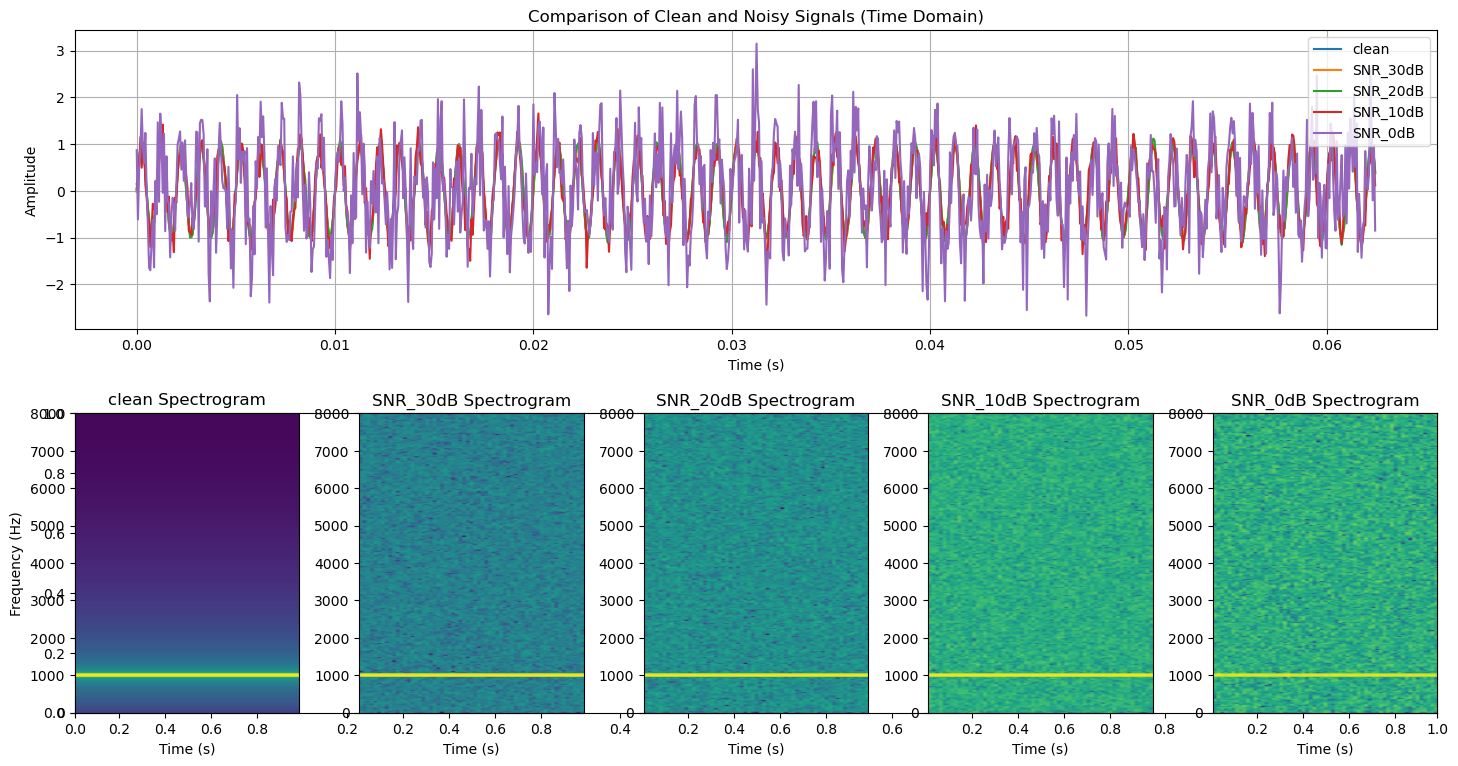

(ULA assumption).
Processing beam pattern for clean...
  Maximum response: -10.63 dB at 0.0°
Processing beam pattern for SNR_30dB...
  Maximum response: -10.63 dB at 0.0°
Processing beam pattern for SNR_30dB...
  Maximum response: -11.16 dB at 0.0°
Processing beam pattern for SNR_20dB...
  Maximum response: -11.16 dB at 0.0°
Processing beam pattern for SNR_20dB...
  Maximum response: -11.30 dB at 0.0°
Processing beam pattern for SNR_10dB...
  Maximum response: -11.30 dB at 0.0°
Processing beam pattern for SNR_10dB...
  Maximum response: -10.02 dB at 0.0°
Processing beam pattern for SNR_0dB...
  Maximum response: -10.02 dB at 0.0°
Processing beam pattern for SNR_0dB...
  Maximum response: -5.79 dB at 0.0°
  Maximum response: -5.79 dB at 0.0°


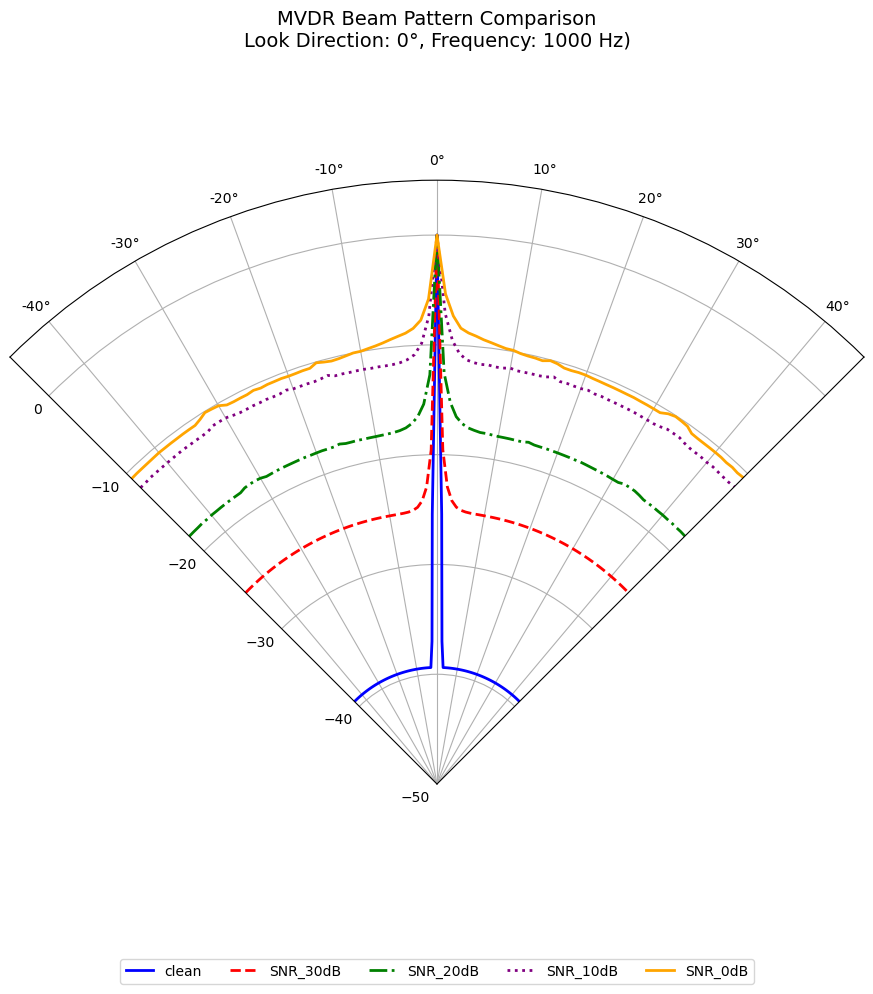

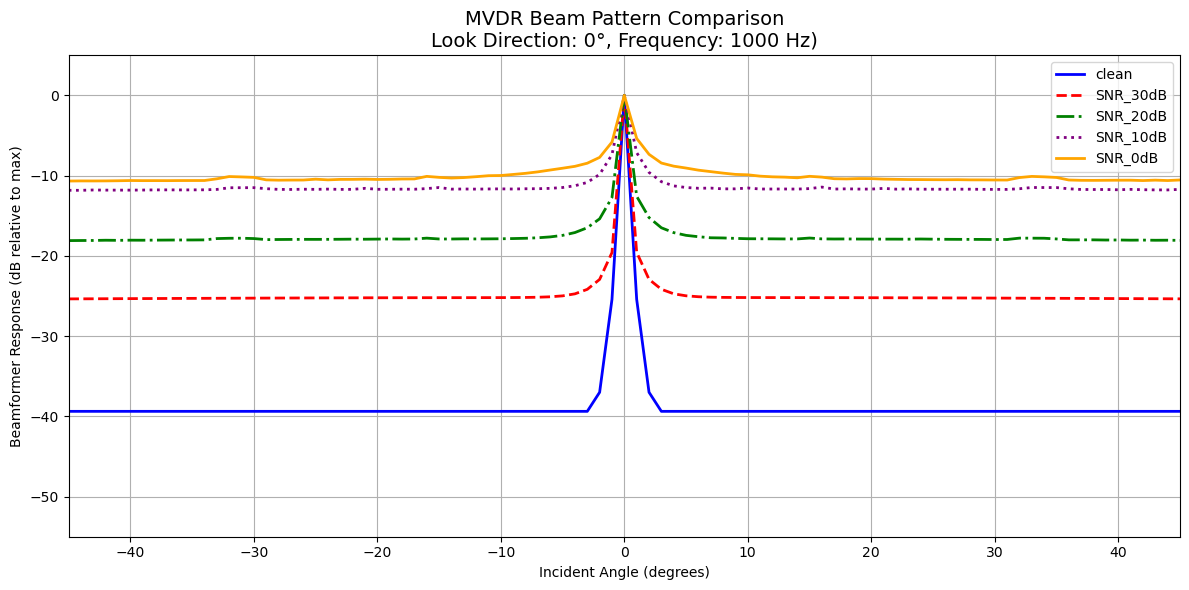


Performance Metrics:
  Signal Type  Beam Width (3dB)  Max Sidelobe Level (dB)  Avg. Rejection (dB)
0       clean               2.0               -39.373176           -39.373176
1    SNR_30dB               2.0               -25.214927           -25.279794
2    SNR_20dB               2.0               -17.782567           -17.958402
3    SNR_10dB               2.0               -11.473578           -11.691110
4     SNR_0dB               2.0               -10.089906           -10.495168


In [9]:
# Main execution flow
params = get_default_params()

# Set parameters for analysis
params["TEST_FREQUENCY"] = 1000      # Hz
params["DURATION"] = 1.0             # seconds
params["SAMPLING_FREQUENCY"] = 16000 # Hz
params["FFT_LENGTH"] = 512           # FFT length
params["FFT_SHIFT"] = 256            # 50% overlap
params["NUM_MICS"] = 8               # Number of microphones
params["LOOK_DIRECTION_DEG"] = 0     # Look direction (degrees)

# Generate signals with different SNR levels
snr_levels = [float('inf'), 30, 20, 10, 0]  # inf = clean, then 30dB, 20dB, 10dB, and 0dB
signals = generate_signals_with_different_snrs(params, snr_levels)

# Setup beamformer
beamformer_setup = setup_beamformer(params)

# Compare beam patterns
results, normalized_results = compare_beam_patterns(params, signals, beamformer_setup)

# Calculate and display performance metrics
metrics_df = calculate_performance_metrics(normalized_results, params)
print("\nPerformance Metrics:")
print(metrics_df)